<a href="https://colab.research.google.com/github/Gabriela2685/Articulo/blob/main/Codigo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  479
Model:                            GLM   Df Residuals:                      470
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -680.88
Date:                Sun, 29 Dec 2024   Deviance:                       154.03
Time:                        05:10:53   Pearson chi2:                     173.
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005403
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6531 

<ipython-input-1-9a7827adf72a>:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-1-9a7827adf72a>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


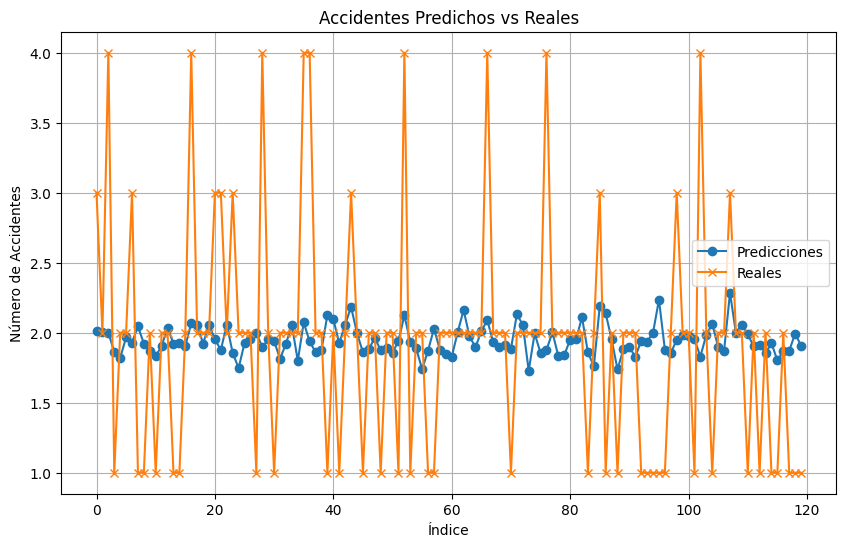

In [ ]:
# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv')

# Convertir variables categóricas en numéricas
data['hora_pico'] = data['hora_pico'].map({'SI': 1, 'NO': 0})
data['horario'] = data['horario'].map({'DIA': 0, 'NOCHE': 1})
data['tipo_de_interseccion'] = data['tipo_de_interseccion'].astype('category').cat.codes
data['dia'] = data['dia'].astype('category').cat.codes
data['dia_1'] = data['dia_1'].map({'Entre semana': 0, 'Fin de semana': 1})
data['mediana'] = data['mediana'].map({'SI': 1, 'NO': 0})  # Nueva variable

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo (actualizada con las nuevas variables)
formula = (
    "acc ~ precipitacion + hora_pico + horario + tipo_de_interseccion + dia + dia_1 + carriles + mediana"
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = "aux_ols_dep ~ lambda_hat - 1"
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo y no muy pequeño
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('\u00cdndice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()
